In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import shap
import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Stap 1: Dataset inladen
df = pd.read_csv("./heart-disease-diagnosis-dataset/dataset_heart.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   270 non-null    int64  
 1   sex                                   270 non-null    int64  
 2   chest pain type                       270 non-null    int64  
 3   resting blood pressure                270 non-null    int64  
 4   serum cholestoral                     270 non-null    int64  
 5   fasting blood sugar                   270 non-null    int64  
 6   resting electrocardiographic results  270 non-null    int64  
 7   max heart rate                        270 non-null    int64  
 8   exercise induced angina               270 non-null    int64  
 9   oldpeak                               270 non-null    float64
 10  ST segment                            270 non-null    int64  
 11  major vessels      

In [4]:
print("Dataset vorm:", df.shape)
print("\nEerste 5 rijen:")
print(df.head())
print("\nBeschrijvende statistieken:")
print(df.describe())
print("\nOntbrekende waarden:", df.isnull().sum())

Dataset vorm: (270, 14)

Eerste 5 rijen:
   age  sex   chest pain type  resting blood pressure  serum cholestoral  \
0   70     1                4                     130                322   
1   67     0                3                     115                564   
2   57     1                2                     124                261   
3   64     1                4                     128                263   
4   74     0                2                     120                269   

   fasting blood sugar  resting electrocardiographic results  max heart rate  \
0                    0                                     2             109   
1                    0                                     2             160   
2                    0                                     0             141   
3                    0                                     0             105   
4                    0                                     2             121   

   exercise induced a

In [5]:
df.isnull().sum()

age                                     0
sex                                     0
chest pain type                         0
resting blood pressure                  0
serum cholestoral                       0
fasting blood sugar                     0
resting electrocardiographic results    0
max heart rate                          0
exercise induced angina                 0
oldpeak                                 0
ST segment                              0
major vessels                           0
thal                                    0
heart disease                           0
dtype: int64

In [6]:
df.describe()

,age,sex,chest pain type,resting blood pressure,serum cholestoral,fasting blood sugar,resting electrocardiographic results,max heart rate,exercise induced angina,oldpeak,ST segment,major vessels,thal,heart disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


In [7]:
mapping = {1: 0, 2: 1}
df['heart disease'] = [mapping[label] for label in df['heart disease']]
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral,fasting blood sugar,resting electrocardiographic results,max heart rate,exercise induced angina,oldpeak,ST segment,major vessels,thal,heart disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [8]:
df.columns

Index(['age', 'sex ', 'chest pain type', 'resting blood pressure',
       'serum cholestoral', 'fasting blood sugar',
       'resting electrocardiographic results', 'max heart rate',
       'exercise induced angina', 'oldpeak', 'ST segment', 'major vessels',
       'thal', 'heart disease'],
      dtype='object')

In [9]:
columns = ['age', 'sex ', 'chest pain type', 'resting blood pressure',
       'serum cholestoral', 'fasting blood sugar',
       'resting electrocardiographic results', 'max heart rate',
       'exercise induced angina', 'oldpeak', 'ST segment', 'major vessels',
       'thal', 'heart disease']

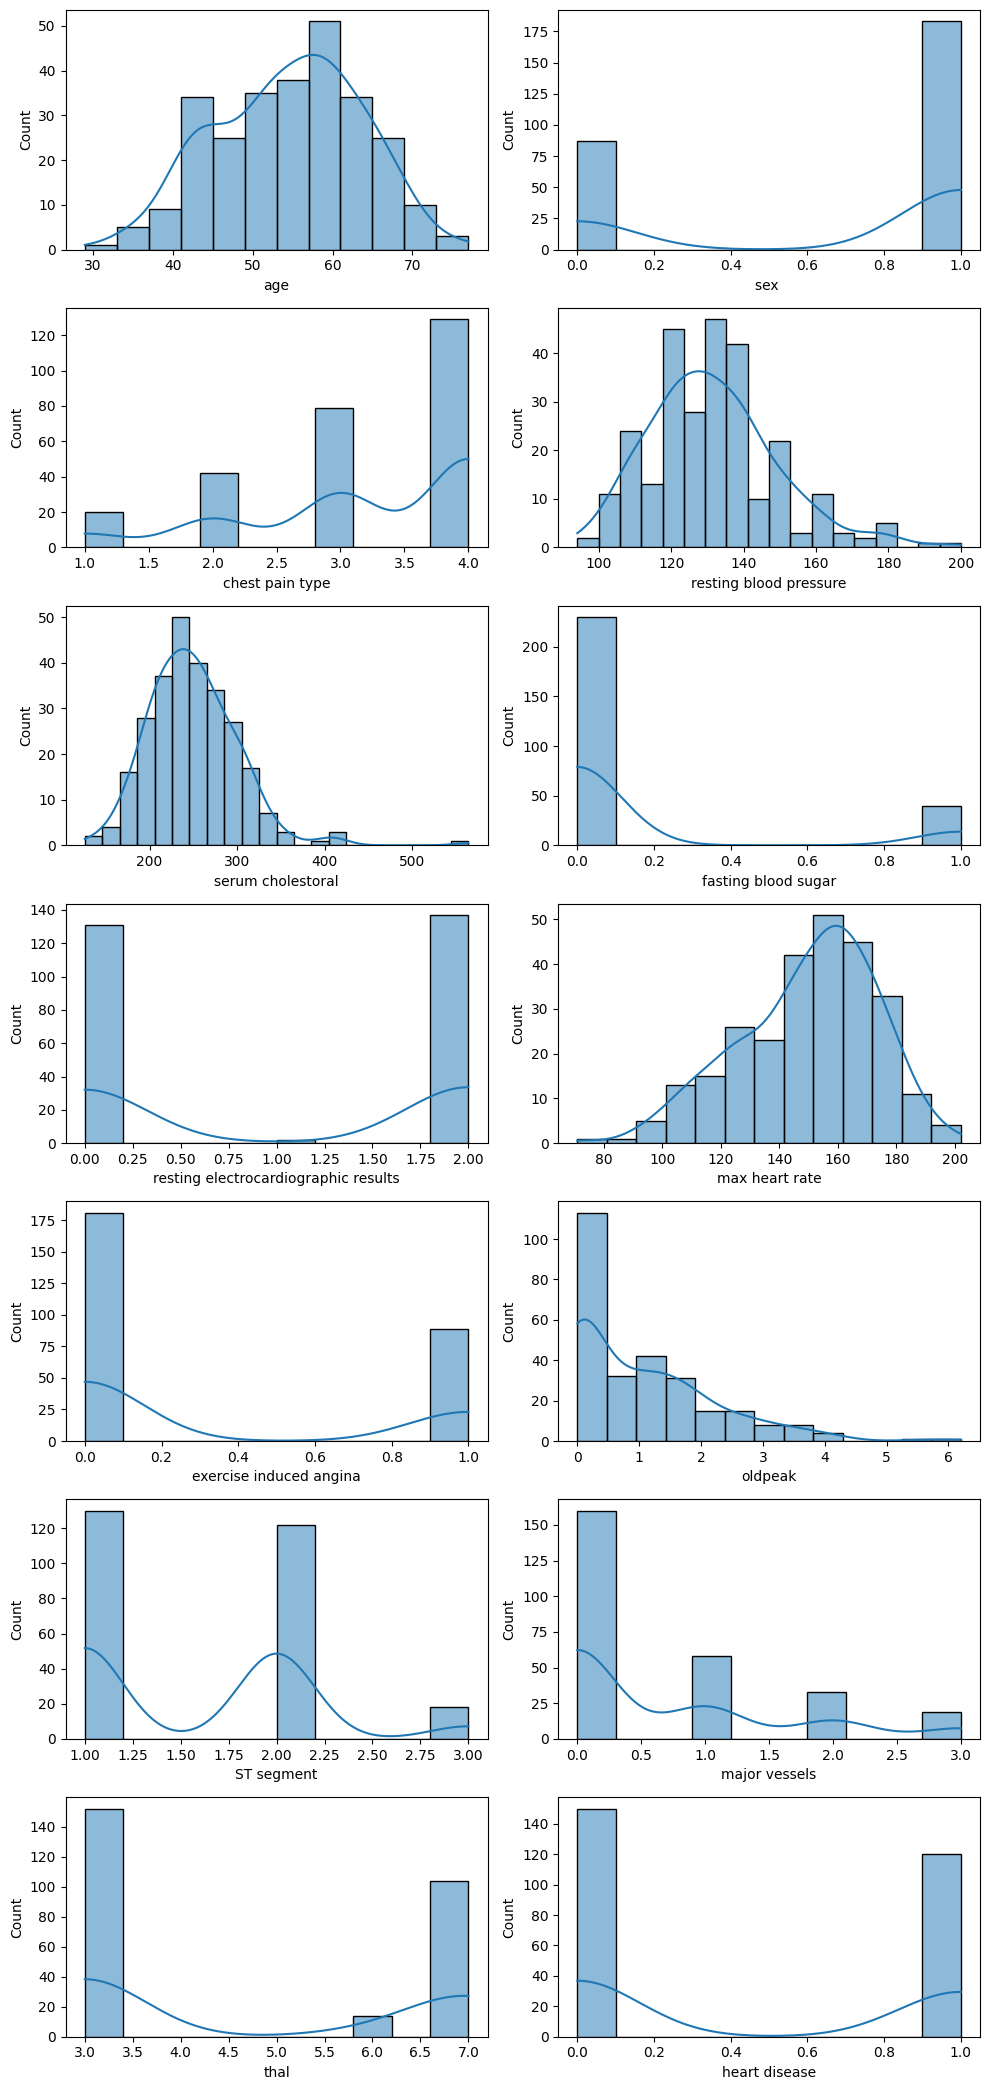

In [10]:
num_rows = (len(columns) + 1) // 2  
plt.figure(figsize=(10, num_rows * 3))

for i, column in enumerate(columns, 1):
    plt.subplot(num_rows, 2, i) 
    sns.histplot(df[column], kde=True)   
    plt.tight_layout() 
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same e

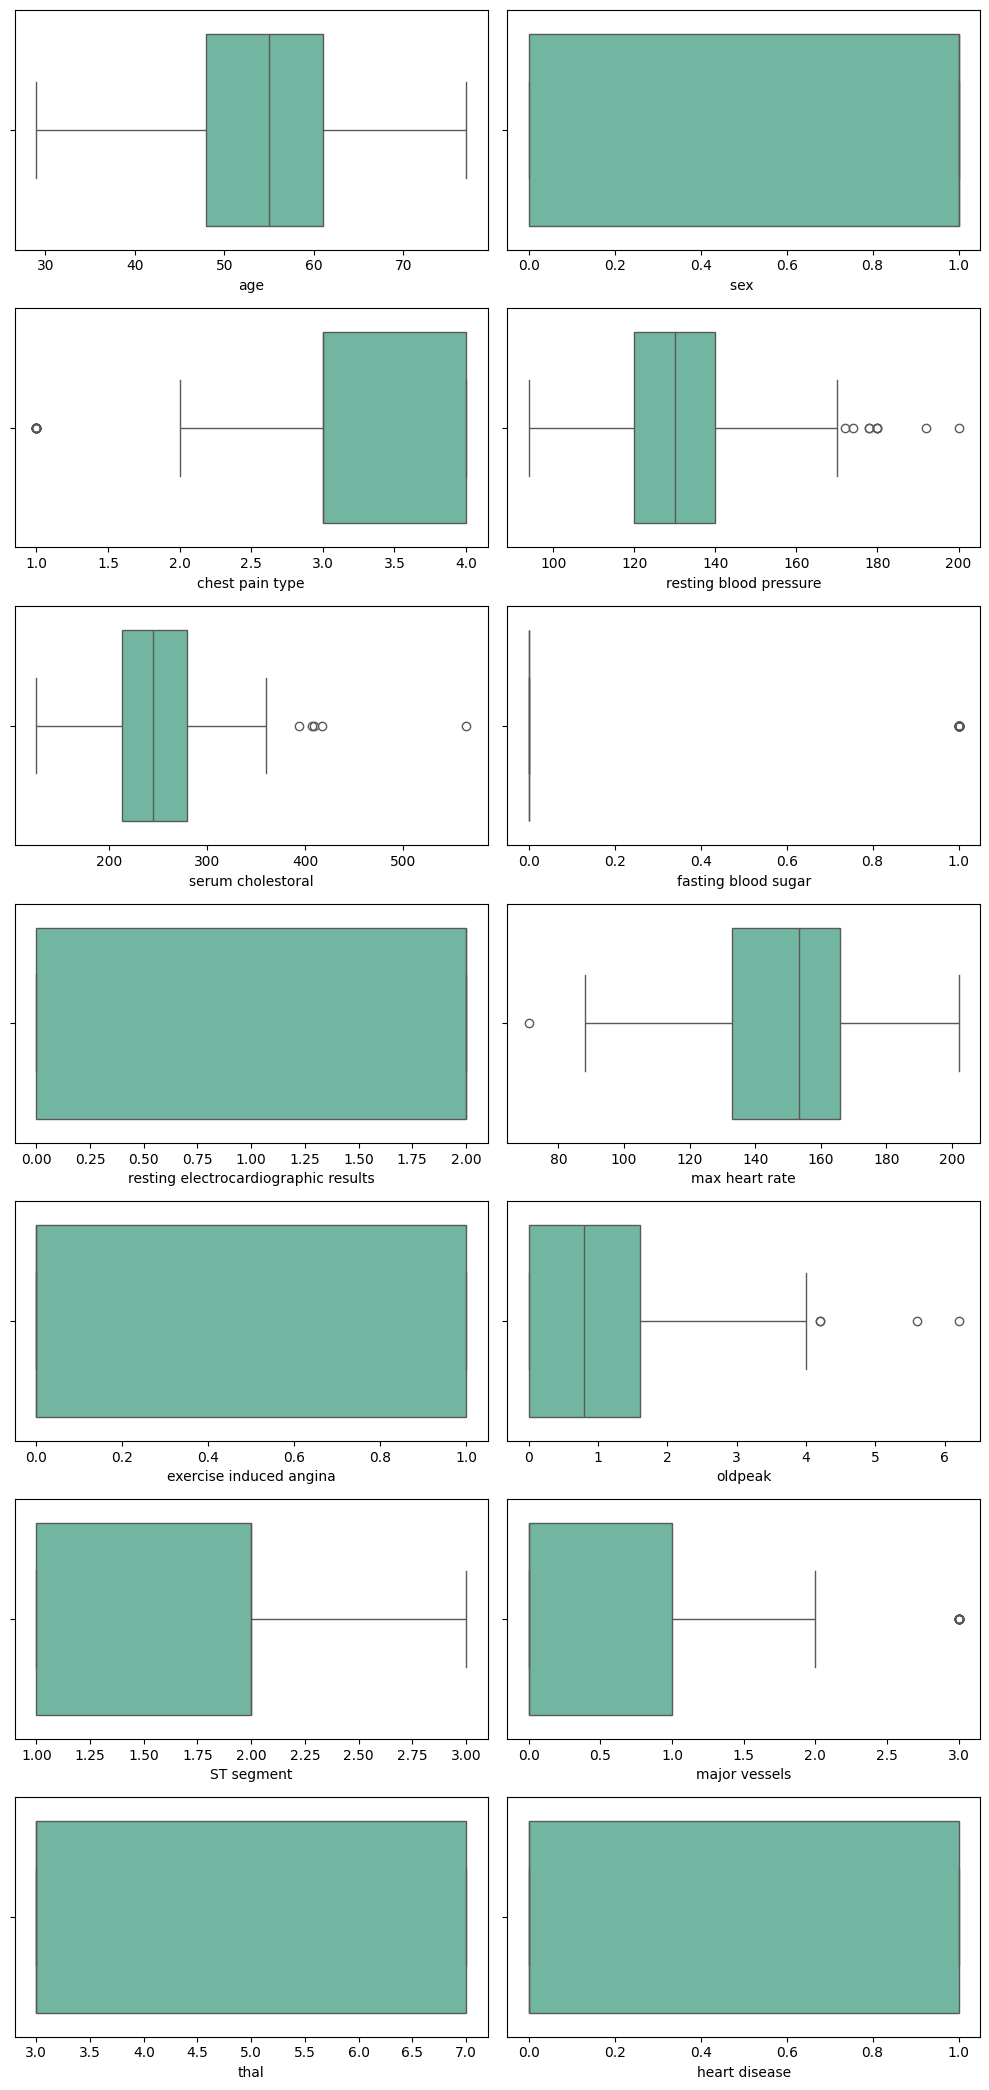

In [11]:
num_rows = (len(columns) + 1) // 2  
plt.figure(figsize=(10, num_rows * 3))

for i, column in enumerate(columns, 1):
    plt.subplot(num_rows, 2, i) 
    sns.boxplot(x=df[column], palette='Set2')  
    plt.tight_layout() 

plt.show()

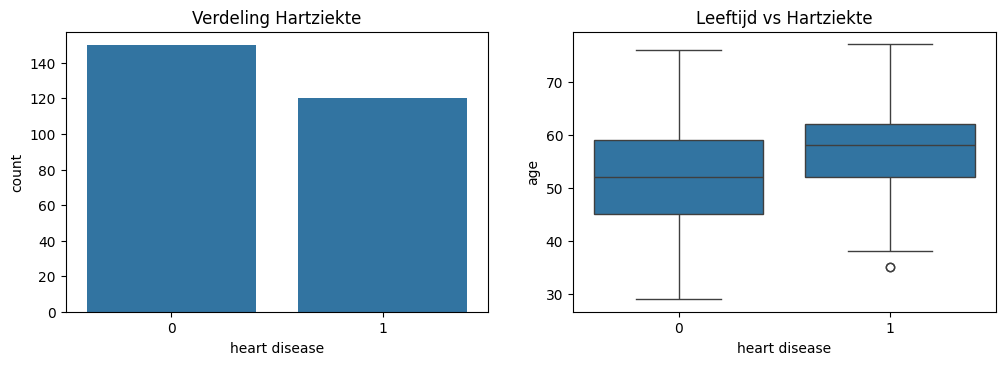

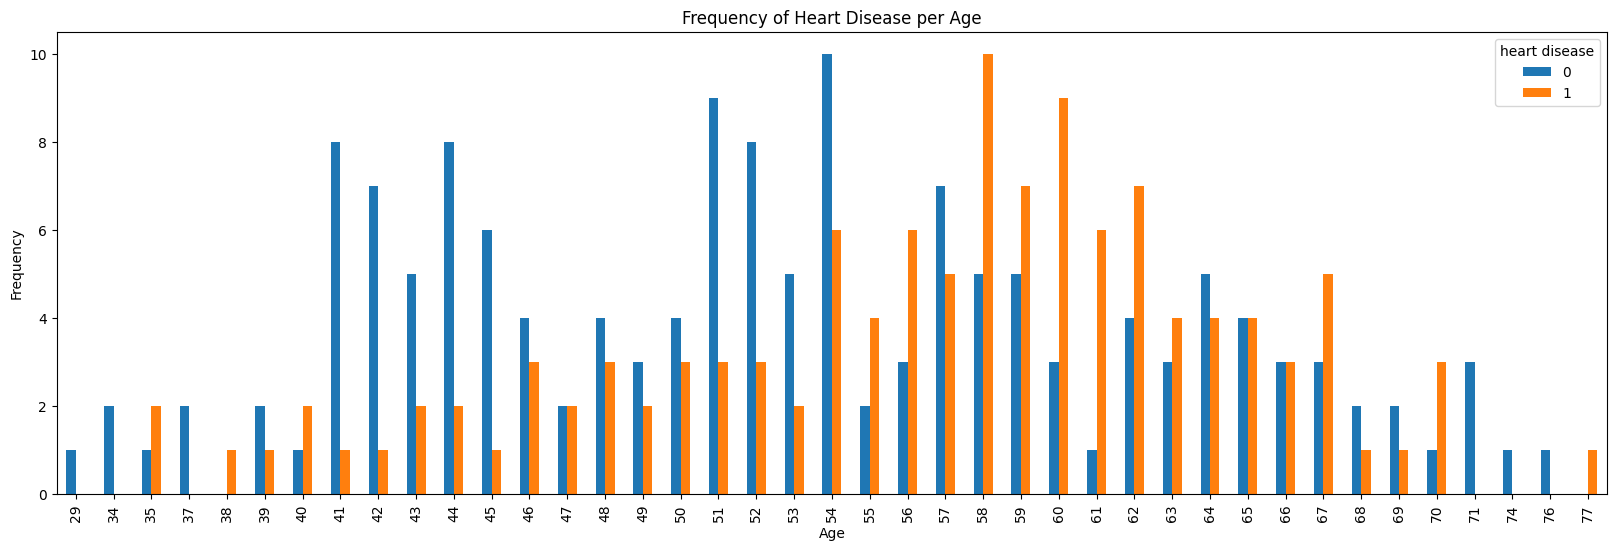

In [12]:
# ---------------
# 3. Uitgebreide EDA met visualisaties
# ---------------
plt.figure(figsize=(12,8))

# Distributie van hartziekte
plt.subplot(2,2,1)
sns.countplot(x='heart disease', data=df)
plt.title('Verdeling Hartziekte')

# Leeftijd vs Hartziekte
plt.subplot(2,2,2)
sns.boxplot(x='heart disease', y='age', data=df)
plt.title('Leeftijd vs Hartziekte')

pd.crosstab(df.age, df['heart disease']).plot(kind="bar", figsize=(20, 6))
plt.title('Frequency of Heart Disease per Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()





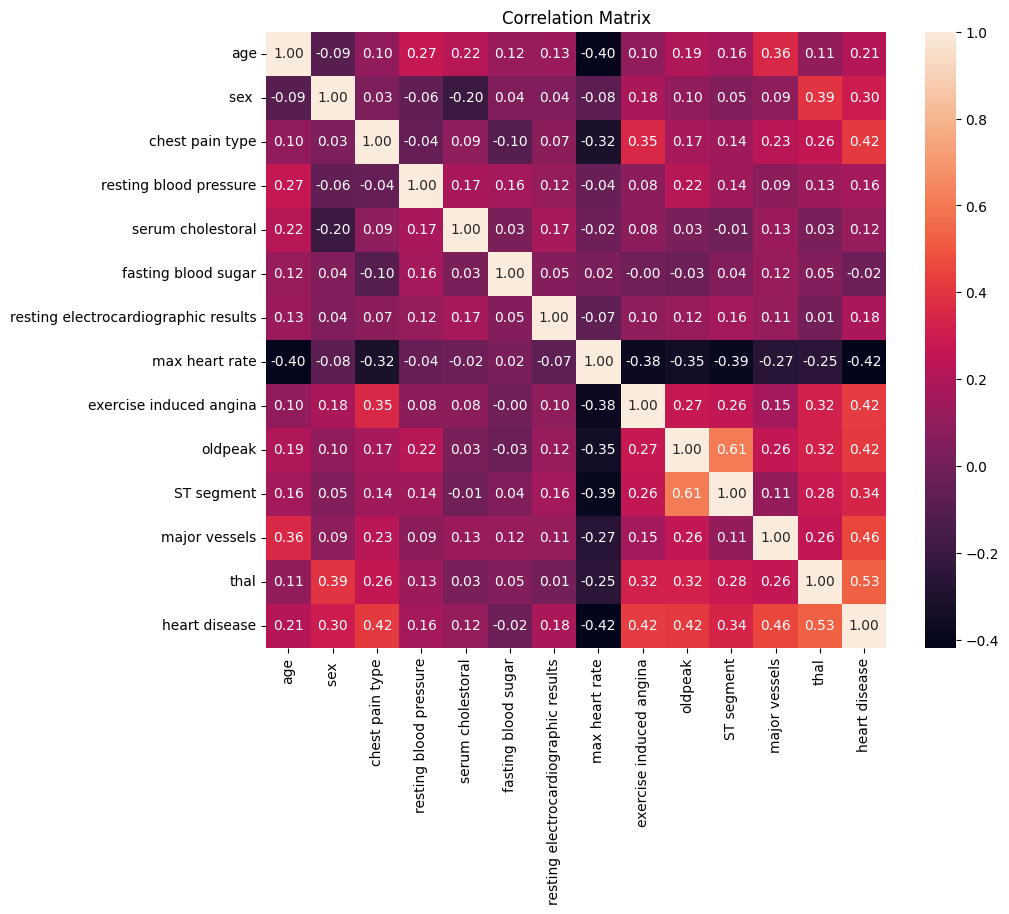

Most important correlations with heart disease:
heart disease                           1.000000
thal                                    0.525020
major vessels                           0.455336
exercise induced angina                 0.419303
oldpeak                                 0.417967
chest pain type                         0.417436
ST segment                              0.337616
sex                                     0.297721
age                                     0.212322
resting electrocardiographic results    0.182091
resting blood pressure                  0.155383
serum cholestoral                       0.118021
fasting blood sugar                    -0.016319
max heart rate                         -0.418514
Name: heart disease, dtype: float64


In [13]:
# Correlatiematrix
corr_matrix = df.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Mapping the most important correlation coefficients with heart disease in table form
important_corr = corr_matrix['heart disease'].sort_values(ascending=False)
print("Most important correlations with heart disease:")
print(important_corr)


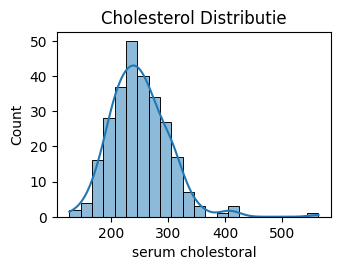

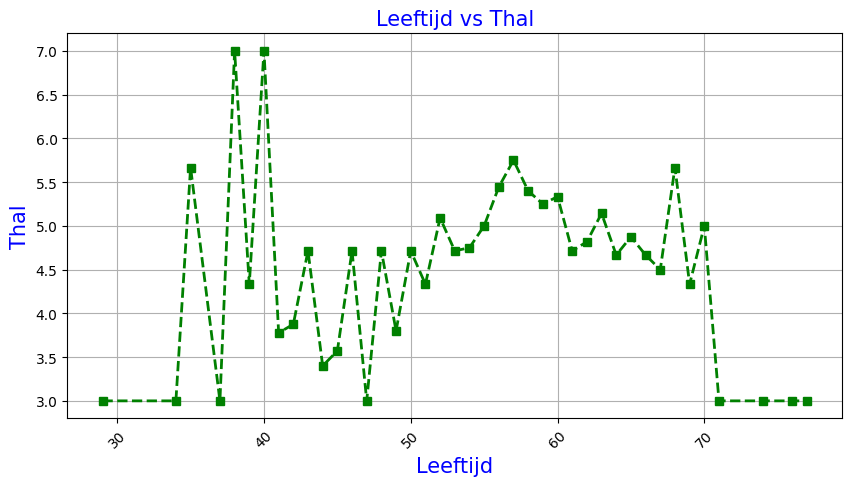

In [14]:
# Feature distributies
plt.subplot(2,2,4)
sns.histplot(df['serum cholestoral'], kde=True)
plt.title('Cholesterol Distributie')

plt.tight_layout()
plt.show()

# thal per age
age_unique = sorted(df.age.unique())
age_thal_values = df.groupby('age')['thal'].count().values
mean_thal = []
for i, age in enumerate(age_unique):
    mean_thal.append(sum(df[df['age'] == age].thal) / age_thal_values[i])

# maken van een line plot
plt.figure(figsize=(10, 5))
plt.plot(age_unique, mean_thal, marker='s', color='green', linestyle='--', linewidth=2)

plt.xlabel('Leeftijd', fontsize=15, color='blue')
plt.xticks(rotation=45)
plt.ylabel('Thal', fontsize=15, color='blue')
plt.title('Leeftijd vs Thal', fontsize=15, color='blue')
plt.grid()

plt.show()

In [15]:
# ---------------
# 4. Data Preprocessing
# ---------------
# Feature engineering
df['age_chol'] = df['age'] * df['serum cholestoral']
df['bp_hr_ratio'] = df['resting blood pressure'] / df['max heart rate']

In [16]:
# Splits data
y = df['heart disease']
X = df.drop('heart disease',axis=1)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# ---------------
# 5. Model Pipeline met SMOTE en Scaling
# ---------------
pipeline = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier())
])

In [19]:
# Hyperparameter tuning
params = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [100, 200]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print(f"Beste parameters: {grid_search.best_params_}")
print(f"Beste ROC-AUC: {grid_search.best_score_:.3f}")

Beste parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Beste ROC-AUC: 0.889



Classificatierapport:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54



Text(0.5, 1.0, 'Confusion Matrix')

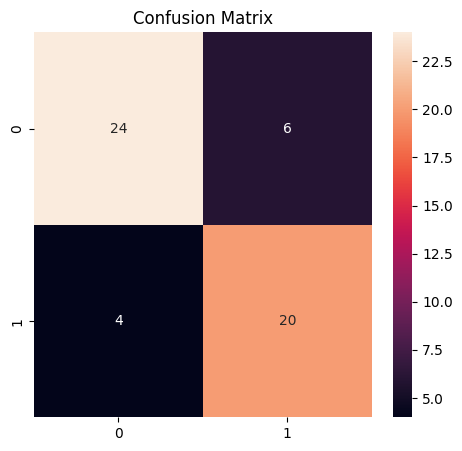

In [20]:
# ---------------
# 6. Model Evaluatie
# ---------------
from sklearn.metrics import roc_curve, auc

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("\nClassificatierapport:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')



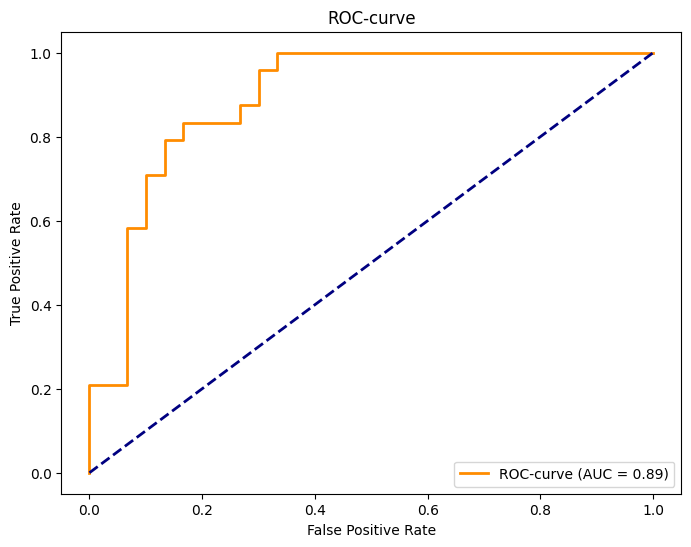

In [21]:
# ROC-curve plot
plt.figure(figsize=(8, 6))  # Expliciet nieuwe figuur
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()

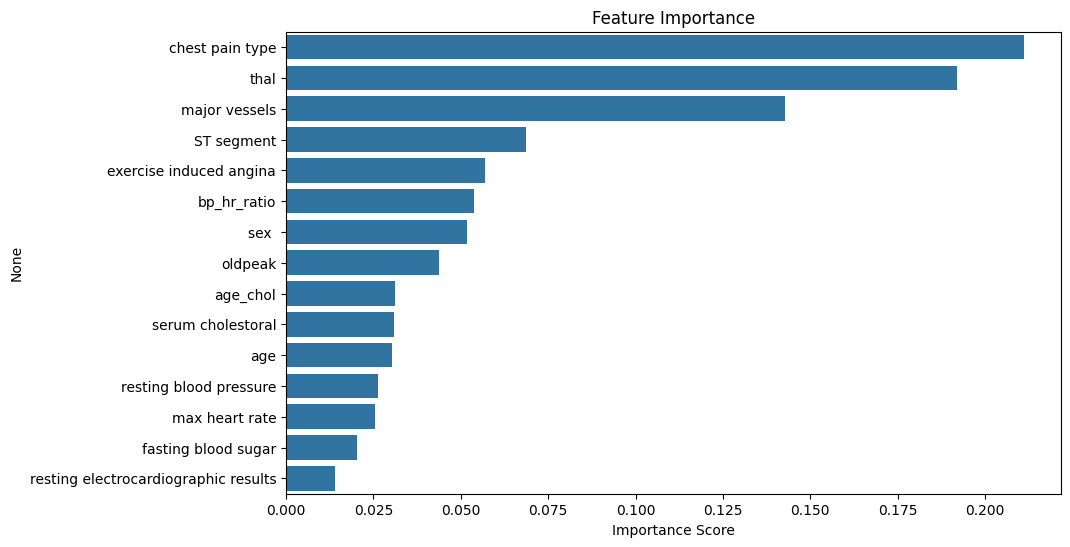

In [22]:
# ---------------
# 7. Feature Importance Analyse
# ---------------
plt.figure(figsize=(10,6))
feature_importance = pd.Series(
    best_model.named_steps['classifier'].feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

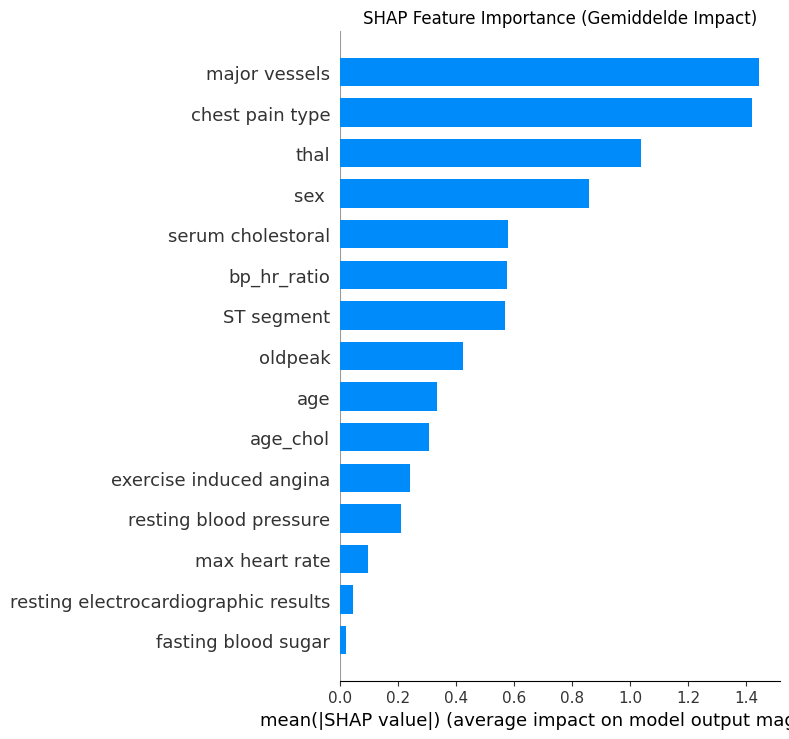

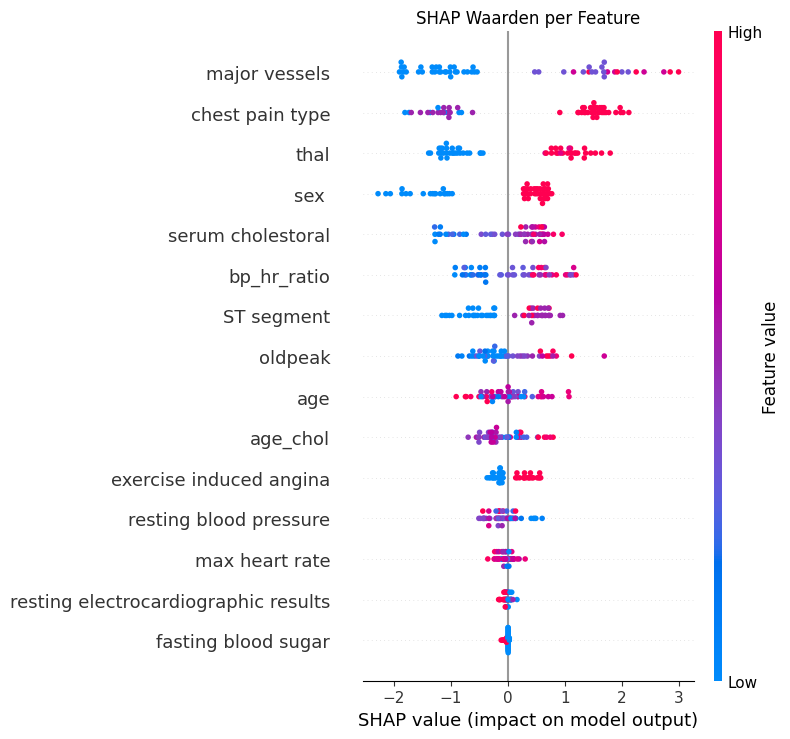

In [23]:
# ---------------
# 8. SHAP Interpretatie
# ---------------
X_test_scaled = pd.DataFrame(
    best_model.named_steps['scaler'].transform(X_test),
    columns=X.columns
)

# SHAP-waarden berekenen
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_scaled)

# Samenvattingsplot met duidelijke parameters
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Gemiddelde Impact)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.title("SHAP Waarden per Feature")
plt.tight_layout()
plt.show()


[17:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

[17:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

[17:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators" } are not used.

[17:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "classifier__learning_rate


Modelvergelijking:
                 Model  Mean ROC-AUC       Std
2        Random Forest      0.906944  0.042806
7           GaussianNB      0.898611  0.028599
0  Logistic Regression      0.895833  0.031950
5                  SVC      0.890833  0.019595
4              XGBoost      0.878333  0.049943
6                  KNN      0.875000  0.023007
3    Gradient Boosting      0.868889  0.042742
8             AdaBoost      0.855000  0.052753
1        Decision Tree      0.750833  0.050854


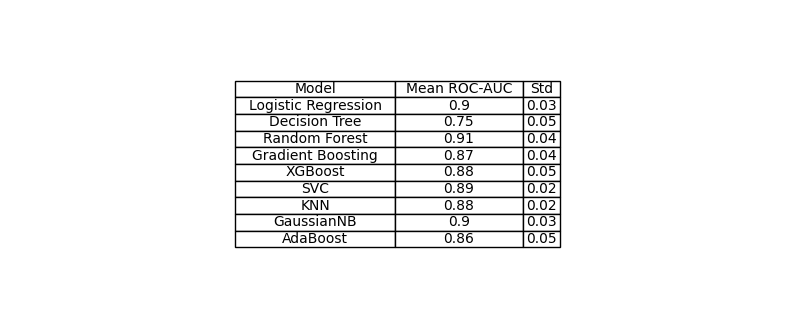

Table saved as 'modeltable_round.png'


In [30]:
# ---------------
# 9. Model Vergelijking
# ---------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
models = {
    "Logistic Regression": LogisticRegression(max_iter=400),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(**grid_search.best_params_),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "AdaBoost": AdaBoostClassifier()
}

results = []

for name, model in models.items():
    pipeline = imbpipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    results.append({
        'Model': name,
        'Mean ROC-AUC': cv_scores.mean(),
        'Std': cv_scores.std()
    })

results_df = pd.DataFrame(results)
print("\nModelvergelijking:")
print(results_df.sort_values('Mean ROC-AUC', ascending=False))

models = pd.DataFrame(results)
models

# --------------- 
# Image  table met resultaten
# --------------- 
import matplotlib.pyplot as plt

# Round the DataFrame values to 2 decimal places
results_df_rounded = results_df.copy()
results_df_rounded['Mean ROC-AUC'] = results_df_rounded['Mean ROC-AUC'].round(2)
results_df_rounded['Std'] = results_df_rounded['Std'].round(2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust size as needed

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create the table
table = plt.table(cellText=results_df_rounded.values, 
                  colLabels=results_df_rounded.columns, 
                  cellLoc='center', 
                  loc='center')

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df_rounded.columns))))

# Save the table as an image
plt.savefig("modeltable_roun.png", bbox_inches='tight', dpi=300)
plt.show()

print("Table saved as 'modeltable_round.png'")





Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



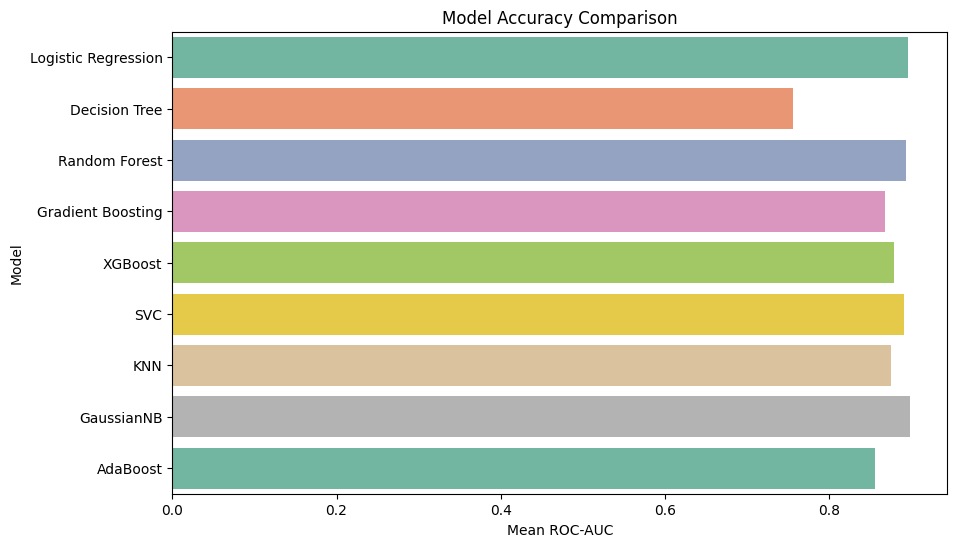

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean ROC-AUC', y='Model', data=models, palette='Set2')
plt.title('Model Accuracy Comparison')
plt.xlabel('Mean ROC-AUC')
plt.ylabel('Model')
plt.show()

Train Accuracy: 84.72%
Test Accuracy: 85.19%
ROC-AUC Score: 89.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54


Cross-Validation Results:
Accuracy: 82.96% (±3.39%)
ROC-AUC: 89.58% (±3.20%)


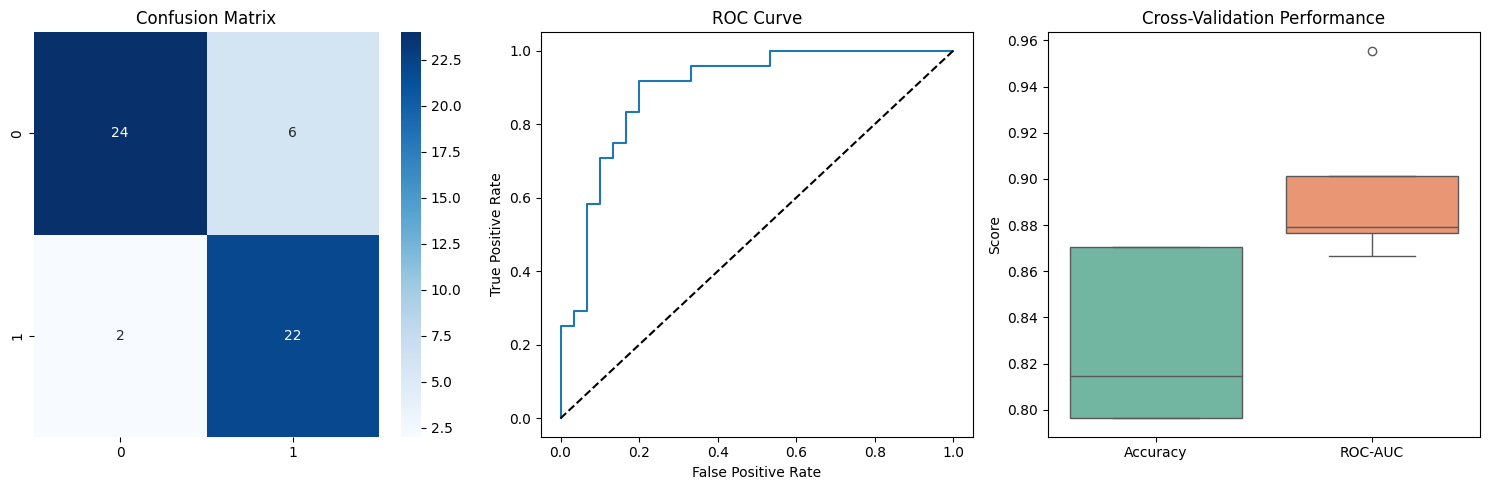


Modelvergelijking (Ascending Order):
                 Model  Mean ROC-AUC       Std
1        Decision Tree      0.750833  0.050854
8             AdaBoost      0.855000  0.052753
3    Gradient Boosting      0.868889  0.042742
6                  KNN      0.875000  0.023007
4              XGBoost      0.878333  0.049943
5                  SVC      0.890833  0.019595
0  Logistic Regression      0.895833  0.031950
7           GaussianNB      0.898611  0.028599
2        Random Forest      0.906944  0.042806


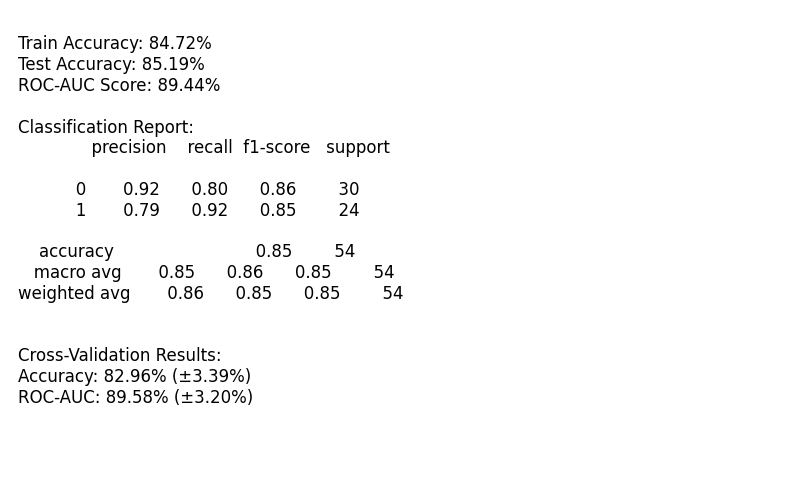

Classification report saved as 'classification_report.png'


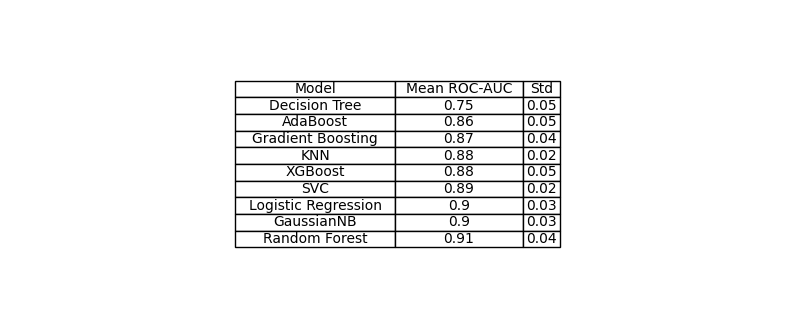

Table saved as 'model_comparison_ascending_order.png'


In [32]:
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, 
                             roc_auc_score, roc_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize model with pipeline
pipeline = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=400))
])

# Fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
train_accuracy = pipeline.score(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_roc_auc = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"ROC-AUC Score: {roc_auc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nCross-Validation Results:")
print(f"Accuracy: {cv_scores.mean():.2%} (±{cv_scores.std():.2%})")
print(f"ROC-AUC: {cv_roc_auc.mean():.2%} (±{cv_roc_auc.std():.2%})")

# Visualizations
plt.figure(figsize=(15, 5))

# 1. Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

# 2. ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2%})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# 3. Cross-Validation Distribution
plt.subplot(1, 3, 3)
sns.boxplot(data=[cv_scores, cv_roc_auc], palette='Set2')
plt.xticks([0, 1], ['Accuracy', 'ROC-AUC'])
plt.title('Cross-Validation Performance')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Sort the model comparison table in ascending order of Mean ROC-AUC
sorted_models = models.sort_values('Mean ROC-AUC', ascending=True)

# Display the sorted table
print("\nModelvergelijking (Ascending Order):")
print(sorted_models)


# --------------- 
# Save classification  and cross vaalidation  as an image
# --------------- 
import matplotlib.pyplot as plt

# Text to display
report_text = """
Train Accuracy: 84.72%
Test Accuracy: 85.19%
ROC-AUC Score: 89.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54


Cross-Validation Results:
Accuracy: 82.96% (±3.39%)
ROC-AUC: 89.58% (±3.20%)
"""

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed
ax.axis('off')  # Turn off the axis

# Add the text
plt.text(0.01, 0.99, report_text, fontsize=12, va='top', ha='left', wrap=True)

# Save the image
plt.savefig("classification_report.png", bbox_inches='tight', dpi=300)
plt.show()

print("Classification report saved as 'classification_report.png'")

# --------------- 
# Save image oof comparison
# --------------- 
import matplotlib.pyplot as plt

# Sort the DataFrame in ascending order of 'Mean ROC-AUC' and round values
sorted_results_df = results_df.sort_values('Mean ROC-AUC', ascending=True).copy()
sorted_results_df['Mean ROC-AUC'] = sorted_results_df['Mean ROC-AUC'].round(2)
sorted_results_df['Std'] = sorted_results_df['Std'].round(2)

# create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4)) 

# hide the axes
ax.axis('tight')
ax.axis('off')

# Create the table
table = plt.table(cellText=sorted_results_df.values, 
                  colLabels=sorted_results_df.columns, 
                  cellLoc='center', 
                  loc='center')

# adjust table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(sorted_results_df.columns))))

# Ssve the table as an image
plt.savefig("model_comparison_ascending_order.png", bbox_inches='tight', dpi=300)
plt.show()

print("Table saved as 'model_comparison_ascending_order.png'")

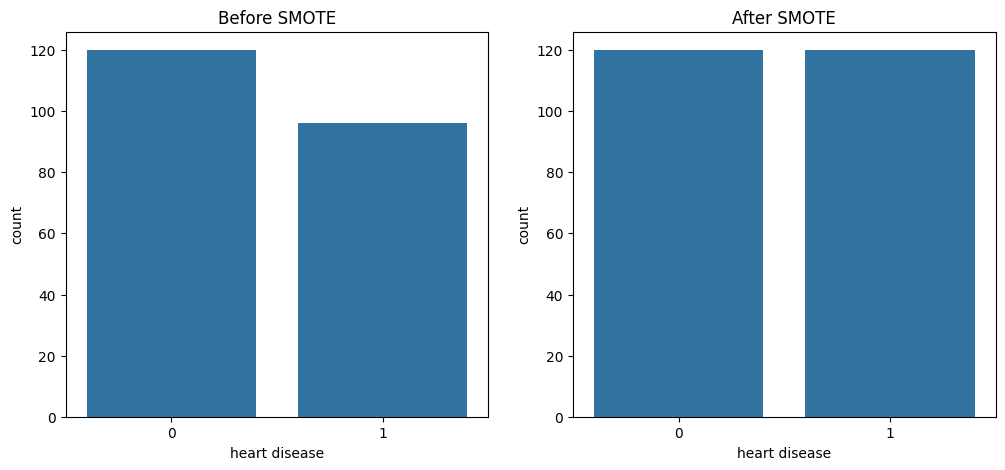

Class Distribution Before SMOTE:
Counter({0: 120, 1: 96})

Class Distribution After SMOTE:
Counter({0: 120, 1: 120})


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter  # Import Counter

# Apply SMOTE to generate resampled data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Visualize the class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Before SMOTE')

# After SMOTE
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('After SMOTE')

plt.show()

# Display the counts in a table format
print("Class Distribution Before SMOTE:")
print(Counter(y_train))

print("\nClass Distribution After SMOTE:")
print(Counter(y_resampled))


In [28]:
# ---------------
# 10. Opslaan model
# ---------------
# joblib.dump(best_model, 'heart_disease_model.pkl')
# print("\nModel opgeslagen als heart_disease_model.pkl")